## VGG transfer learning

This notebook is an example of training a classification VGGFace model on preprocessed images. The VGGFace model can be found here https://github.com/rcmalli/keras-vggface The images are based on the 'Faces in the wild' dataset http://vis-www.cs.umass.edu/lfw/. The faces are preprocessed in another notebook CV2_process which results in a collection folders with pictures (240 picture in 17 classes). These folders are read, labels are set and the data is formatted so that it can be used by the VGGFace model. A train and test set are made and the model is configured and trained. The trained model is evaluated in different ways.


In [1]:
import numpy as np
import os
import time
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from keras.preprocessing.image import load_img
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

Using TensorFlow backend.
/usr/lib64/python3.4/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Loading the training data
PATH = os.getcwd()
# Define data path
data_path = PATH + '/output3'
data_dir_list = os.listdir(data_path)

img_data_list=[] # data of the read pictures 
imagenames=[] # a list of filenames that is used to find the original pictures when the testdata is predicted
classes = [] # the classes that are used
label_list = [] # list of labels (integers) of all images

#'.ipynb_checkpoints' are hidden files created by Jupyter that must be removed from the lists of read folders and files
if '.ipynb_checkpoints' in data_dir_list:
    data_dir_list.remove('.ipynb_checkpoints')
x=0
for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    if '.ipynb_checkpoints' in img_list:
        img_list.remove('.ipynb_checkpoints')
    for img in img_list:
        imagenames.append(img)
        label_list.append(x)
        img_path = data_path + '/'+ dataset + '/'+ img
        # Although the files are already preprocessed this is done again in case pictures of other sources are used
        imgfile = image.load_img(img_path, target_size=(224, 224, 3))
        imgfile = image.img_to_array(imgfile)
        imgfile = np.expand_dims(imgfile, axis=0)
        imgfile = utils.preprocess_input(imgfile, version=1)
        img_data_list.append(imgfile)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    classes.append(dataset)
    x=x+1

Loaded the images of dataset-Bill_Simon

Loaded the images of dataset-Britney_Spears

Loaded the images of dataset-Dick_Cheney

Loaded the images of dataset-Halle_Berry

Loaded the images of dataset-Harrison_Ford

Loaded the images of dataset-Howard_Dean

Loaded the images of dataset-Jeb_Bush

Loaded the images of dataset-Jennifer_Garner

Loaded the images of dataset-John_Snow

Loaded the images of dataset-Meryl_Streep

Loaded the images of dataset-Nancy_Pelosi

Loaded the images of dataset-Naomi_Watts

Loaded the images of dataset-Nicole_Kidman

Loaded the images of dataset-Richard_Gephardt

Loaded the images of dataset-Salma_Hayek

Loaded the images of dataset-Sergey_Lavrov

Loaded the images of dataset-Ann_Veneman



In [4]:
# Save the classes to a file so they can be used when new data is classified with the stored model.
np.savetxt("classes.csv", classes, fmt='%s', delimiter=",")

In [5]:
# Reshape data
img_data = np.array(img_data_list)
print (img_data.shape)
img_data = img_data.reshape((1, len(img_data_list), 224, 224, 3))[0]
img_data.shape

(240, 1, 224, 224, 3)


(240, 224, 224, 3)

In [6]:
num_of_samples = img_data.shape[0]
num_classes = len(classes)

In [7]:
# convert class labels to on-hot encoding
lab = np.asarray(label_list)
Y = np_utils.to_categorical(lab, num_classes)

In [8]:
#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [9]:
# Custom_vgg_model_1
#Training the classifier alone
nr_epochs = 5
image_input = Input(shape=(224, 224, 3))

# The pretrained model including the top (classification layer of 2622 classes)
model = VGGFace(input_tensor=image_input, include_top=True,weights='vggface')
model.summary()

# the top is removed and a new layer is defined and connected to the last existing layer
last_layer = model.get_layer('fc8').output
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_vgg_model = Model(image_input, out)
custom_vgg_model.summary()

# Only the last (classification) layer must be trained
for layer in custom_vgg_model.layers[:-1]:
	layer.trainable = False

custom_vgg_model.layers[3].trainable

custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])


t=time.time()
#	t = now()
trainhist = custom_vgg_model.fit(X_train, y_train, batch_size=32, epochs=nr_epochs, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_vgg_model.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

192/192 [==============================] - 203s - loss: 0.0048 - acc: 1.0000 - val_loss: 0.3239 - val_acc: 0.9167
Training time: -1018.0754764080048
48/48 [==============================] - 40s    
[INFO] loss=0.3239, accuracy: 91.6667%


In [10]:
# Make a prediction on the trained model
yhat = custom_vgg_model.predict(X_test)
yhat.shape

(48, 17)

In [11]:
#The result is an array with the probabilities per class (17) per picture
yhat[0]

array([  9.81722534e-01,   6.48859132e-05,   2.13421896e-04,
         1.21326975e-05,   8.91392585e-03,   2.88097450e-04,
         1.08581036e-03,   6.13865996e-05,   1.46400140e-04,
         5.97341568e-04,   5.52208576e-06,   6.42547337e-03,
         5.37521046e-05,   1.05558584e-05,   9.69041139e-07,
         4.70430386e-05,   3.50746996e-04], dtype=float32)

Make a list of the labels of the predictions and the reference (y)

In [12]:
results = []
for pred in yhat:
    top_indices = pred.argsort()[-1:][::-1]
    result = [[str(classes[i]), pred[i]] for i in top_indices]
    result.sort(key=lambda x: x[1], reverse=True)
    results.append(result[0][0])

In [13]:
#y_test
y_ref = []
for pred in y_test:
    top_indices = pred.argsort()[-1:][::-1]
    result = [[str(classes[i]), pred[i]] for i in top_indices]
    result.sort(key=lambda x: x[1], reverse=True)
    y_ref.append(result[0][0])

In [14]:
# Find the erroneous pictures and return the labels and index in X_test en y_test
errornr=[]
for i, _ in enumerate(results):
    if y_ref[i]!=results[i]:
        print(i, y_ref[i], results[i])
        errornr.append(i)
errornr

9 Harrison_Ford Richard_Gephardt
14 Jennifer_Garner Salma_Hayek
15 Salma_Hayek Meryl_Streep
21 Nancy_Pelosi Meryl_Streep


[9, 14, 15, 21]

These are the errors that occur when the testset is applied on the trained model. A picture of Harrison Ford is classified as Richard Gephardt etc

In [15]:
# Find the index in input and the name of the erroneous pictures 
photonr=[]
picter=[]
for er in errornr:
    for n, _ in enumerate(img_data_list):
        if (X_test[er]==img_data_list[n]).all():
            photonr.append(n)
            print(imagenames[n])
            picter.append(imagenames[n])
photonr

Harrison_Ford_0003_0.jpg
Jennifer_Garner_0004_0.jpg
Salma_Hayek_0009_0.jpg
Nancy_Pelosi_0015_0.jpg


[61, 98, 213, 152]

In [16]:
# Show the erroneous pictures. Fresh load is needed as the preprocessing leads to bad quality pictures. 
# First the searching and reading.....

import os
import cv2

rootdir ='output3/'
images=[]
for subdir, dirs, files in os.walk(rootdir):
    for pict in picter:
        for file in files:
            if file == pict:
                img = cv2.imread(subdir + '/' +file)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # needed to format the cv2 colors to the right format 
                images.append(img)

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


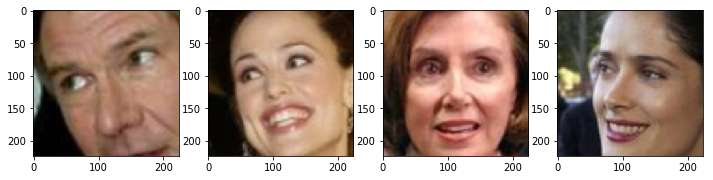

In [17]:
# ...... then showing
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig=plt.figure(figsize=(12,12 ))
n=1
x=len(images)
for face in images:
        fig.add_subplot(1,x,n)
        plt.imshow(np.asarray(face))
        n=n+1 

The model is trained on frontal faces. So it has troubles classifying pictures from aside. 

It's interesting to check the probabilities of the erroneous pictures

In [18]:
top=5
ereval = []
for pred in yhat:
    top_indices = pred.argsort()[-top:][::-1]
    erev = [[str(classes[i]), pred[i]] for i in top_indices]
    erev.sort(key=lambda x: x[1], reverse=True)
    ereval.append(erev)

In [19]:
for i in errornr:
    print("reference:", y_ref[i], ",predicted:", results[i])
    [print(*line) for line in ereval[i]]
    print("")

reference: Harrison_Ford ,predicted: Richard_Gephardt
Richard_Gephardt 0.515951
Sergey_Lavrov 0.172377
Jeb_Bush 0.129046
Dick_Cheney 0.105529
Harrison_Ford 0.0381297

reference: Jennifer_Garner ,predicted: Salma_Hayek
Salma_Hayek 0.820726
Nancy_Pelosi 0.154282
Jennifer_Garner 0.0148535
Nicole_Kidman 0.00469395
Bill_Simon 0.00257932

reference: Salma_Hayek ,predicted: Meryl_Streep
Meryl_Streep 0.910336
Bill_Simon 0.061777
Salma_Hayek 0.02249
Nicole_Kidman 0.00120118
Nancy_Pelosi 0.00102493

reference: Nancy_Pelosi ,predicted: Meryl_Streep
Meryl_Streep 0.665155
Nancy_Pelosi 0.310349
Bill_Simon 0.0145635
Harrison_Ford 0.00254882
John_Snow 0.00225638



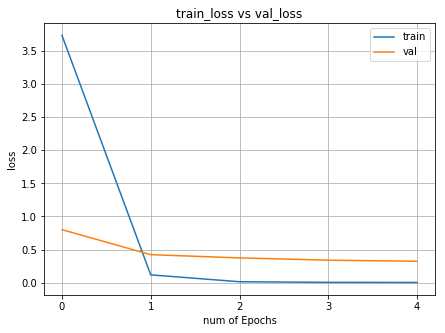

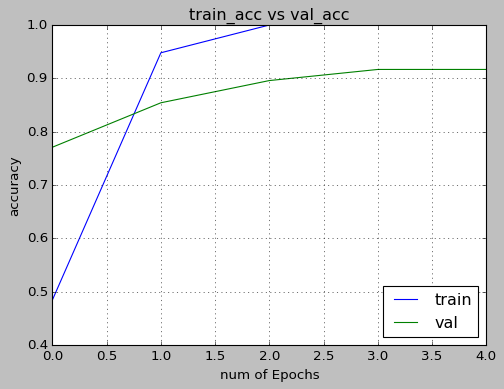

In [20]:
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=trainhist.history['loss']
val_loss=trainhist.history['val_loss']
train_acc=trainhist.history['acc']
val_acc=trainhist.history['val_acc']
xc=range(nr_epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
plt.show()

The graphs shows that the model is learning very fast. Only 2 epochs are needed to get a good  performance on the trainset. Of course the model is only learning the classificiation (last layer) so the effort is relatively small. As training neural networks is a stochastic process the accuracy may vary per training cycle. So the training should be repeated several times using different training and testsets to get the average accuracy.

In [21]:
# Storing the model on disk
from keras.models import model_from_json

# serialize model to JSON
model_json = custom_vgg_model.to_json()
with open("model_lfw.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
custom_vgg_model.save_weights("model_lfw.h5")
print("Saved model to disk")

Saved model to disk


## Training the feature extraction too

In case you want to train the feature extraction the full connected part of the model (the last three layers) can be retrained. In the code below these three layers are replaced. The model now needs considerable more epochs and time to train.

In [ ]:
image_input = Input(shape=(224, 224, 3))

model = VGGFace(input_tensor=image_input, include_top=True,weights='vggface')

model.summary()

last_layer = model.get_layer('pool5').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_vgg_model2 = Model(image_input, out)
custom_vgg_model2.summary()

# freeze all the layers except the dense layers
for layer in custom_vgg_model2.layers[:-3]:
	layer.trainable = False

custom_vgg_model2.summary()

custom_vgg_model2.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

t=time.time()
#	t = now()
trainhist = custom_vgg_model2.fit(X_train, y_train, batch_size=32, epochs=12, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_vgg_model2.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

#%%
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=trainhist.history['loss']
val_loss=trainhist.history['val_loss']
train_acc=trainhist.history['acc']
val_acc=trainhist.history['val_acc']
xc=range(12)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])